In [1]:
import pandas as pd
import numpy as np
import gzip
from tqdm.notebook import tqdm

In [2]:
import torch

In [8]:
nad_prots = pd.read_csv('/projects/bpms/jlaw/inputs/nad_nadp/kegg_nad_uniprot.txt', header=None).squeeze()
print(nad_prots.head())

0    A0A6J0JUL3
1    A0A5Q0QDC4
2        B5XZX7
3    A0A6G7YB72
4        D0A1U1
Name: 0, dtype: object


In [9]:
nadp_prots = pd.read_csv('/projects/bpms/jlaw/inputs/nad_nadp/kegg_nadp_uniprot.txt', header=None).squeeze()
print(nadp_prots.head())

0    A0A1D8P7Q7
1    A0A7L5Y0F6
2    A0A6J0JUL3
3        E0RUK3
4        C5D5T3
Name: 0, dtype: object


In [11]:
prot_set = set(nad_prots) | set(nadp_prots)

In [18]:
print(len(prot_set))

566753


In [3]:
# copied from here: https://stackoverflow.com/a/29805905/7483950
def read_fasta(fp, gzipped=False):
        name, seq = None, []
        for line in fp:
            if gzipped:
                line = line.decode()
            line = line.rstrip()
            if line.startswith(">"):
                if name: yield (name, ''.join(seq))
                name, seq = line[1:], []
            else:
                seq.append(line)
        if name: yield (name, ''.join(seq))

In [17]:
fasta_file = "/projects/deepgreen/jlaw/inputs/uniprot/2021-05/2021-05-25-uniprot_swissprot_trembl_shortid.fasta.gz"
print(f"reading {fasta_file}")
sequences = {}
# prot_set = set(prots)
with gzip.open(fasta_file, 'r') as f:
    for name, seq in tqdm(read_fasta(f, gzipped=True), total=214406399):
        # just read in the proteins that have GO annotations
        if name not in prot_set:
            continue
        # make sure there aren't these strange AAs
        seq = seq.replace('B', 'D').replace('Z', 'E').replace('J', 'L')
#         print(name, seq)
        sequences[name] = seq

print(f"\t{len(sequences)} read")

reading /projects/deepgreen/jlaw/inputs/uniprot/2021-05/2021-05-25-uniprot_swissprot_trembl_shortid.fasta.gz


  0%|          | 0/214406399 [00:00<?, ?it/s]

	566571 read


### Also try using manual evidence of binding from UniProt
See /projects/bpms/jlaw/gapn-engineering/data/nad_nadp

I downloaded these nadp and nad examples from uniprot from here:
https://www.uniprot.org/uniprot/?query=annotation%3A%28type%3Abinding+nadp+evidence%3Amanual%29+OR+annotation%3A%28type%3Anp_bind+nadp+evidence
https://www.uniprot.org/uniprot/?query=annotation%3A%28type%3Abinding+nad+evidence%3Amanual%29+OR+annotation%3A%28type%3Anp_bind+nad+evidence%3

This is what I used in the search bar:
annotation:(type:binding nad evidence:manual) OR annotation:(type:np_bind nad evidence:manual)
annotation:(type:binding nadp evidence:manual) OR annotation:(type:np_bind nadp evidence:manual)

I noticed that proteins that use NAD or NADP have binding sites listed with NAD(P) and/or regions of nucleotide binding with NAD(P).
So those searches are for either of htose evidence types

In [4]:
def read_fasta_file(fasta_file, prot_set=None):
    sequences = {}
    # prot_set = set(prots)
    gzipped = fasta_file.endswith('.gz')
    open_func = gzip.open if gzipped else open
    with open_func(fasta_file, 'r') as f:
        for name, seq in tqdm(read_fasta(f, gzipped=gzipped)):
            # just read in the proteins that have GO annotations
            if prot_set and name not in prot_set:
                continue
            # make sure there aren't these strange AAs
            seq = seq.replace('B', 'D').replace('Z', 'E').replace('J', 'L')
    #         print(name, seq)
            sequences[name] = seq
    return sequences

In [47]:
data_dir = "/projects/bpms/jlaw/gapn-engineering/data"
nad_file = f"{data_dir}/nad_nadp/2022_02_25_uniprot_binding_nad.fasta"
nadp_file = f"{data_dir}/nad_nadp/2022_02_25_uniprot_binding_nadp.fasta"
nad_seqs = read_fasta_file(nad_file)
nadp_seqs = read_fasta_file(nadp_file)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [6]:
all_seqs = {**nad_seqs, **nadp_seqs}
print(f"{len(nad_seqs)} NAD seqs, {len(nadp_seqs)} NADP seqs, {len(all_seqs)} combined")

10894 NAD seqs, 6737 NADP seqs, 17031 combined


In [18]:
# model_name = "esm1_t6_43M_UR50S"
model_name = "esm1b_t33_650M_UR50S"
torch.hub.set_dir('/scratch/jlaw/torch')
# torch.hub.set_dir('/gpfs/alpine/scratch/jlaw/bie108/torch/hub')
model, alphabet = torch.hub.load("facebookresearch/esm:main", model_name)
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
model = model.eval()
model = model.to(device)
batch_converter = alphabet.get_batch_converter()
# get the representations from the last layer 
repr_layer = model.num_layers

Using cache found in /scratch/jlaw/torch/facebookresearch_esm_main


In [8]:
import time

In [23]:
from torch.cuda.amp import GradScaler
from torch.cuda.amp import autocast

In [39]:
# generate the embeddings for these sequences
def get_seq_embeddings(model, seqs, repr_layer=33, batch_size=16):
    """
    Generate an embedding for every sequence using the specified model
    """
    scaler = GradScaler()
    batch_labels, batch_strs, batch_tokens = batch_converter(list(zip(np.arange(len(seqs)), seqs)))

    batch_dataloader = torch.utils.data.DataLoader(batch_tokens, 
                                                   batch_size=batch_size, 
                                                   pin_memory=True,
                                                   num_workers=8
                                                  )

    representations = []
    with torch.no_grad():
        for batch_idx, batch in tqdm(enumerate(batch_dataloader), total=len(batch_dataloader)):
            out = model(batch.to(device), repr_layers=[repr_layer])  # because this is the 33-layer transformer
            out = out['representations'][repr_layer].detach().to('cpu').numpy()

            for i in range(len(batch)):
                representations += [out[i, 1:len(batch[i]) + 1].mean(0).astype(np.float16)]
    representations = np.vstack(representations)
    return representations

In [40]:
seq_labels = sorted(all_seqs)
seqs = [all_seqs[l] for l in seq_labels]
seqs = [seq[:1022] if len(seq) > 1022 else seq for seq in seqs]
with autocast():
    representations = get_seq_embeddings(model, seqs, repr_layer=repr_layer, batch_size=64)

  0%|          | 0/267 [00:00<?, ?it/s]

In [43]:
'Q59931' in nadp_seqs

True

In [57]:
representations.shape

(17031, 1280)

In [44]:
X = representations
y = [1 if s in nad_seqs else 0 for s in seq_labels]

In [53]:
sum(y)

10894

In [60]:
(len(y_test) - sum(y_test)) / len(y_test)

0.35691223950689754

/home/jlaw/.local/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


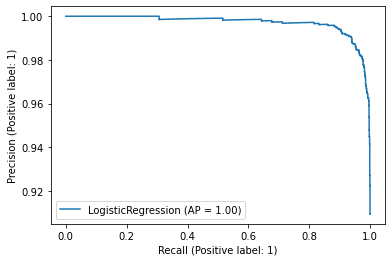

In [45]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# Reserve 20% of the data for validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)

from sklearn.metrics import plot_precision_recall_curve

plot_precision_recall_curve(log_reg, X_test, y_test)

In [50]:
# also load the GapN mutant data and compare the NAD+/NADP+ activity
new_gapn_data_file = f"{data_dir}/20211018-GapN-data-up-to-SM160.csv"
gapn_data = pd.read_csv(new_gapn_data_file, index_col=0)
# drop the barcode of the sequences: MGSSHHHHHHSSGLVPRGSH
gapn_data['Sequence'] = gapn_data['Sequence'].apply(lambda x: x.replace('MGSSHHHHHHSSGLVPRGSH', '').strip('*'))

gapn_reps = get_seq_embeddings(model, gapn_data['Sequence'], repr_layer=repr_layer)

  0%|          | 0/6 [00:00<?, ?it/s]

<AxesSubplot:xlabel='NAD+_initial_rate', ylabel='NADP+_initial_rate'>

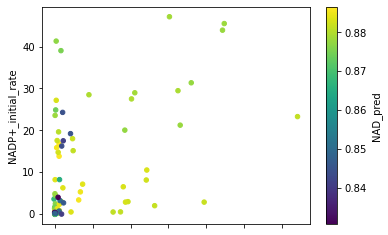

In [56]:
# now train on all training data
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X, y)

nad_prob = log_reg.predict_proba(gapn_reps)[:,1].ravel()
gapn_data['NAD_pred'] = nad_prob
gapn_data.plot.scatter(x="NAD+_initial_rate", y="NADP+_initial_rate", c="NAD_pred", cmap="viridis")

In [ ]:
# try training a neural net instead


In [61]:
import torch
from torch import nn
import pytorch_lightning as pl
import torchmetrics

In [62]:
class NeuralNetwork(pl.LightningModule):
    def __init__(self, initial_layer_size=1280):
        super(NeuralNetwork, self).__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(initial_layer_size, 512),
            nn.ReLU(),
            # nn.Linear(512, 1),            
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 1),
            # nn.ReLU(),
        )

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits    

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        loss = nn.functional.mse_loss(y_pred, y)
        self.log('train_loss', loss)
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        loss = nn.functional.mse_loss(y_pred, y)        
        self.log("val_loss", loss)
        
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

In [63]:
def fit_predict(X_train, y_train, X_valid):
    pl.seed_everything(42)
    model = NeuralNetwork(initial_layer_size=X_train.shape[1])
    
    trainer = pl.Trainer(
        gpus=-1,
        max_steps=400,
        log_every_n_steps=4,
        progress_bar_refresh_rate=0.)
    
    train_dataset = torch.utils.data.TensorDataset(torch.Tensor(X_train), torch.Tensor(y_train))
    # valid_dataset = torch.utils.data.TensorDataset(torch.Tensor(X_valid), torch.Tensor(y_valid))

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True)
    # valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=16, shuffle=False)

    trainer.fit(model, train_loader)
    
    return model(torch.Tensor(X_valid)).detach().numpy()

In [64]:
pred = fit_predict(X_train, y_train, X_test).flatten()

Global seed set to 42
/lustre/eaglefs/projects/deepgreen/jlaw/envs/fairseq/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0.0)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  f"Setting `Trainer(progress_bar_refresh_rate={progress_bar_refresh_rate})` is deprecated in v1.5 and"
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/lustre/eaglefs/projects/deepgreen/jlaw/envs/fairseq/lib/python3.7/site-packages/pytorch_lightning/trainer/configuration_validator.py:118: UserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn("You defined a `

In [68]:
pred

array([0.6091909 , 0.540318  , 0.51736826, ..., 0.52739394, 0.56902933,
       0.5313288 ], dtype=float32)

<AxesSubplot:>

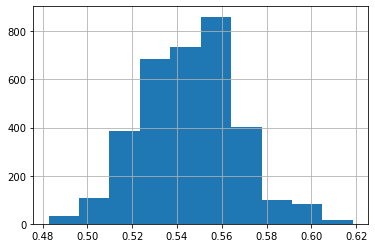

In [69]:
S = pd.Series(pred)
S.hist()

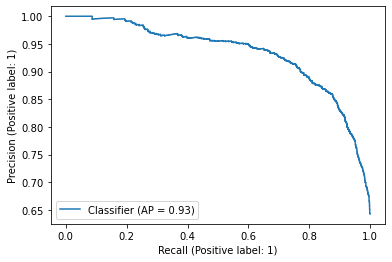

In [67]:
from sklearn.metrics import PrecisionRecallDisplay
PrecisionRecallDisplay.from_predictions(y_test, pred)

In [77]:
gapn_pred = fit_predict(X, y, gapn_reps).flatten()

Global seed set to 42
/lustre/eaglefs/projects/deepgreen/jlaw/envs/fairseq/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0.0)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  f"Setting `Trainer(progress_bar_refresh_rate={progress_bar_refresh_rate})` is deprecated in v1.5 and"
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/lustre/eaglefs/projects/deepgreen/jlaw/envs/fairseq/lib/python3.7/site-packages/pytorch_lightning/trainer/configuration_validator.py:118: UserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn("You defined a `

<AxesSubplot:>

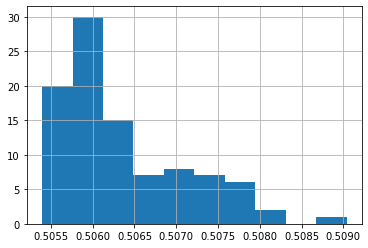

In [79]:
S = pd.Series(gapn_pred)
S.hist()

<AxesSubplot:xlabel='NAD+_initial_rate', ylabel='NADP+_initial_rate'>

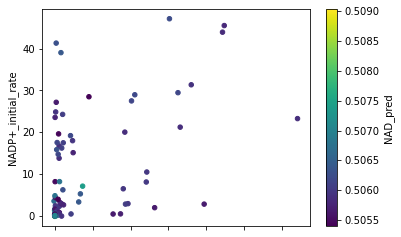

In [81]:
# now train on all training data
# log_reg = LogisticRegression(max_iter=1000)
# log_reg.fit(X, y)

gapn_data['NAD_pred'] = gapn_pred
gapn_data.plot.scatter(x="NAD+_initial_rate", y="NADP+_initial_rate", c="NAD_pred", cmap="viridis")

In [5]:
from esm import Alphabet, FastaBatchedDataset, ProteinBertModel, pretrained

In [6]:
# default batch size from esm: 4096
toks_per_batch = 16
dataset = FastaBatchedDataset.from_file(nad_file)
batches = dataset.get_batch_indices(toks_per_batch, extra_toks_per_seq=1)
data_loader = torch.utils.data.DataLoader(
    dataset, collate_fn=alphabet.get_batch_converter(), batch_sampler=batches
)

representations = {}
for batch_idx, (labels, strs, toks) in tqdm(enumerate(data_loader)):
#     # see how much memory is being used
#     if batch_idx % 1000 == 0:
#         print_memory_usage()
    result = model(toks.to(device="cuda", non_blocking=True), repr_layers=[repr_layer])
    out = result['representations'][repr_layer].detach().cpu().numpy()
    for i, label in enumerate(labels):
        # Generate per-sequence representations via averaging
        # NOTE: token 0 is always a beginning-of-sequence token, so the first residue is token 1.
        representations[label] = out[i, 1 : len(strs[i]) + 1].mean(0)

0it [00:00, ?it/s]

ValueError: Sequence length 1088 above maximum  sequence length of 1024